# Time Series Data forcasting with LSTM

## Loading the required libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger
from datetime import datetime
%matplotlib inline

Using TensorFlow backend.


## Loading and exploring the Dow Jones Industrial Average Index data
The downloaded data contain the daily price data between '2008-08-08' and '2016-07-01'
for ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

In [2]:
df = pd.read_csv('DJIA_table.csv', parse_dates=['Date'], index_col=['Date'] )

# Sort the data based on date in ascendating order i.e oldest date first
df = df.sort_index(ascending=True)

# A quick check on dataframe structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 6 columns):
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1)
memory usage: 108.8 KB
None


In [3]:
# We will only use 'Volume' and 'Close' as the features from the daily price data
columns=['Volume','Close']
df = df[columns]

In [4]:
# We will re-sample the data to weeky data
df = df.resample('1W').mean()

#Use next day/week 'Close' price will become the label for the current day/week
df['Y'] = df['Close'].shift(-1)

# Adding some major US economic indicators as the features
We will add the main US economic indicators as our features which normally would impact the direction of the financial market index.
All the indicator numbers are published monthly and the data are downloaded from https://fred.stlouisfed.org/

## CPI
The Consumer Price Index (CPI) is the benchmark inflation guide for the U.S. economy. It uses a "basket of goods" approach that aims to compare a consistent base of products from year to year, focusing on products that are bought and used by consumers on a daily basis. The price of your milk, eggs, toothpaste and a hair cut are all captured in the CPI.

Read more: Economic Indicators: Consumer Price Index (CPI) http://www.investopedia.com/university/releases/cpi.asp#ixzz4vvozFvGP 


## IPI
The industrial production index (IPI) is an economic indicator that is released monthly by the Federal Reserve Board. The indicator measures the amount of output from the manufacturing, mining, electric and gas industries.

Read more: Industrial Production Index (IPI) http://www.investopedia.com/terms/i/ipi.asp#ixzz4vvodHXSx 


## NFP
The nonfarm payroll report is a major tool used to determine the overall health of the economy. The total nonfarm payroll accounts for approximately 80% of the workers who produce the entire gross domestic product (GDP) of the United States.

Read more: Nonfarm Payroll http://www.investopedia.com/terms/n/nonfarmpayroll.asp#ixzz4vvphLwhs 

## RetailSales
Known as a key leading economic indicator, retail sales reports reflect statistics culled from 5,000 retail outlets and food service entities. With consumer spending accounting for approximately two-thirds of GDP, retail sales are viewed as a major driver of the economic health of a nation.

Read more: Retail Sales http://www.investopedia.com/terms/r/retail-sales.asp#ixzz4vvq1hSBT


In [5]:
indicators = pd.read_csv('us_indicators.csv', parse_dates=['Date'], index_col=['Date'] )

# Our index data start from 2008-08-10
indicators =indicators[indicators.index > '2008-08-09']


# A quick check on dataframe structure
print(indicators.info())
print(indicators.head(3))
print(indicators.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 413 entries, 2008-08-10 to 2016-07-03
Data columns (total 4 columns):
NFP            413 non-null float64
IPI            413 non-null float64
CPI            413 non-null float64
RetailSales    413 non-null float64
dtypes: float64(4)
memory usage: 16.1 KB
None
                 NFP       IPI     CPI  RetailSales
Date                                               
2008-08-10  137230.0  100.8875  218.69     333836.0
2008-08-17  137230.0  100.8875  218.69     333836.0
2008-08-24  137230.0  100.8875  218.69     333836.0
                 NFP       IPI      CPI  RetailSales
Date                                                
2016-06-19  144166.0  103.1249  239.842     405580.0
2016-06-26  144166.0  103.1249  239.842     405580.0
2016-07-03  144457.0  103.2173  239.898     404835.0


In [6]:
# Merge the 2 data frames
#df = pd.concat([df, indicators] , axis=0, join_axes=[df.index])
df = pd.merge(df, indicators, how='inner', left_index=True, right_index=True)
df.tail(5)

,Volume,Close,Y,NFP,IPI,CPI,RetailSales
Date,,,,,,,
2016-06-05,95937500.0,17805.622559,17942.837891,144166.0,103.1249,239.842,405580.0
2016-06-12,76422000.0,17942.837891,17691.146094,144166.0,103.1249,239.842,405580.0
2016-06-19,126038000.0,17691.146094,17765.450000,144166.0,103.1249,239.842,405580.0
2016-06-26,122204000.0,17765.450000,17624.800000,144166.0,103.1249,239.842,405580.0
2016-07-03,114500000.0,17624.800000,NaN,144457.0,103.2173,239.898,404835.0


In [7]:
# Since we are shifting the data upward, the last row of the dataframe is containing 'Nan' value for Y
# We will remove this 
df = df[:-1]
print(df.tail(5))

                 Volume         Close             Y       NFP       IPI  \
Date                                                                      
2016-05-29   79116000.0  17750.400000  17805.622559  143869.0  102.7552   
2016-06-05   95937500.0  17805.622559  17942.837891  144166.0  103.1249   
2016-06-12   76422000.0  17942.837891  17691.146094  144166.0  103.1249   
2016-06-19  126038000.0  17691.146094  17765.450000  144166.0  103.1249   
2016-06-26  122204000.0  17765.450000  17624.800000  144166.0  103.1249   

                CPI  RetailSales  
Date                              
2016-05-29  239.362     401076.0  
2016-06-05  239.842     405580.0  
2016-06-12  239.842     405580.0  
2016-06-19  239.842     405580.0  
2016-06-26  239.842     405580.0  


In [8]:
# Re-arrange the columns
df = df[['CPI', 'IPI', 'NFP', 'RetailSales', 'Volume', 'Close', 'Y']]
df_copy = df.copy()
#print(df_copy.info())
df_Y = df_copy[['Y']]
df_Y.info()
#type(df_Y.values)
#df_Y.values.shape
#df_Y[:3]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 412 entries, 2008-08-10 to 2016-06-26
Freq: W-SUN
Data columns (total 1 columns):
Y    412 non-null float64
dtypes: float64(1)
memory usage: 6.4 KB


# Quick visualization of the features and label


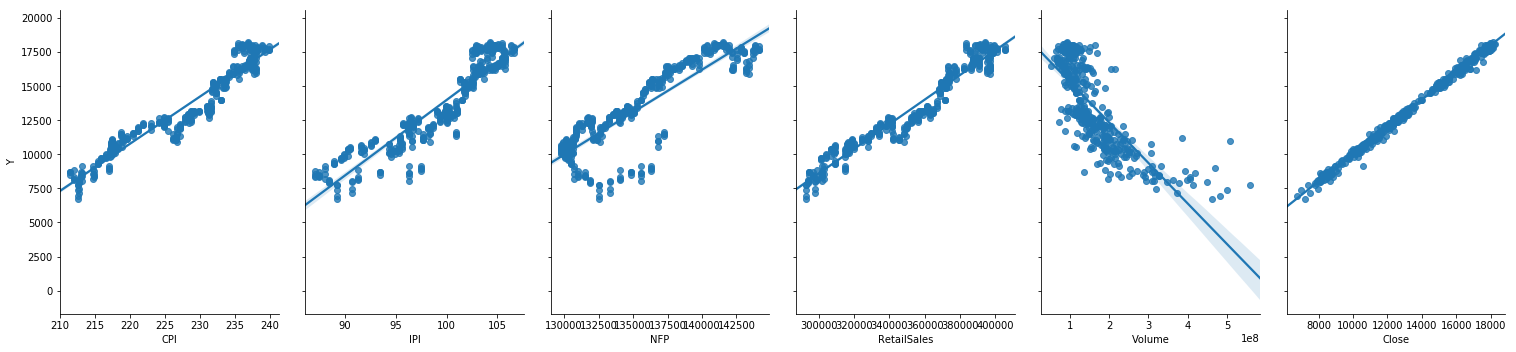

In [9]:
x_features=['CPI', 'IPI', 'NFP', 'RetailSales', 'Volume', 'Close']
sns.pairplot(df, x_vars=x_features, y_vars='Y', size=5, aspect=0.7, kind='reg')

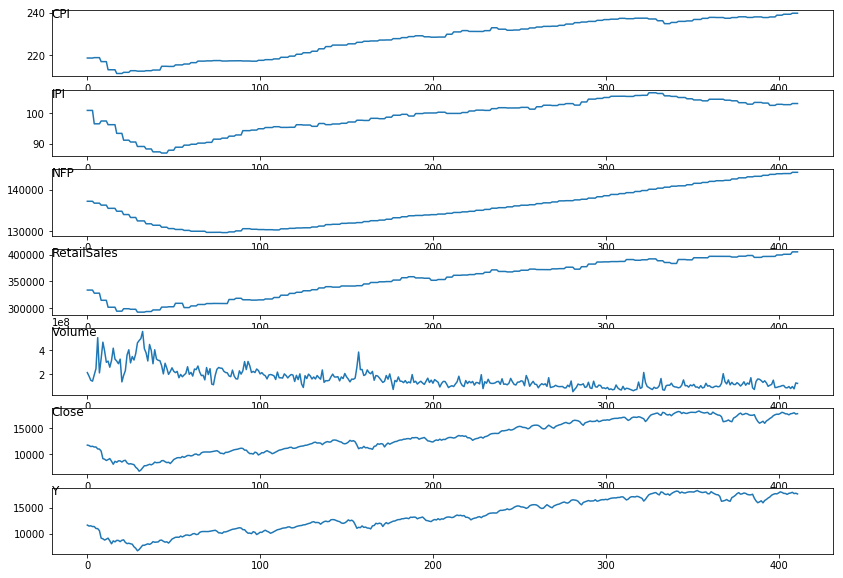

In [10]:
def create_subplot(df):
    values = df.values
    # specify columns to plot
    groups = range(len(df.columns))
    i = 1
    # plot each column
    pyplot.figure(figsize=(14,10))
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(df.columns[group], y=0.8, loc='left')
        i += 1
    pyplot.show()

create_subplot(df)

## Convert to stationary time series

In [11]:
# convert time series into supervised learning problem
def timeseries_to_supervised(data, dropnan=True):
    dataframe=DataFrame()
    for col in data.columns:
        #col_diff = col + "_diff"
        dataframe[col] = data[col].shift(-1) - data[col]
    # drop nan rows
    if dropnan:
        dataframe.dropna(inplace=True)
    return dataframe


# scale data
def scale(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # transform data
    scaled_data = scaler.fit_transform(data)
    return scaler, scaled_data

# inverse scaling for a forecasted value
def invert_scale(scaler, data):
    inverted = scaler.inverse_transform(data)
    return inverted


def split_train_test(scaled_data, split_ratio=0.45):
    # Split data into train and test scaled_data 
    train_size = int(len(scaled_data) * split_ratio)
    test_size = len(scaled_data) - train_size
    train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
    #print(len(scaled_data), len(train), len(test))
    #print(scaled_data.shape, train.shape, test.shape)

    # Split data into features X, and lable y
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    #print("\ntrain_X and train_y shape")
    #print(train_X.shape, train_y.shape)
    #print(test_X.shape, test_y.shape)
    
    return train_X, train_y, test_X, test_y, train_size



def reshape_to_orig(x,y):
    '''
    Merging x and y into its original series shape.
    
    Reshape x from (rows_count,1,cols_count) => (rows_count,cols_count) 
    and concat with y in the shape (rows_count,1)
    For example: (88, 1, 5) + (88, 1) => (88,6)
    
    '''
    return np.hstack((x.reshape(len(x),x.shape[2]), y))

def calculate_rmse(model, train_X, train_y, test_X, test_y, scaler, df_Y, train_size ):
    
    #predict the model
    #print('Predicting train and test data')
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    # Calling reshape_to_orig function to reshape both the training and test data
    #print('Reshaping the data')
    trainPredict = reshape_to_orig(train_X, trainPredict)
    testPredict = reshape_to_orig(test_X,testPredict)
 
    # invert the scale 
    #print('Inverting the scale')
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    #testY_orig = scaler.inverse_transform(testY2)

    # invert the diff Add the diff with the Close price
    '''
    print('\nInverting the diff for Y_Predict')
    print(trainPredict.shape, testPredict.shape)
    print('\nSecond last col')
    print(trainPredict[:3,-2])
    print('\nLast col')
    print(trainPredict[:3,-1])
    print('\nActual Y')
    print(df_Y[:3])
    print('df_y shape', df_Y.shift(-1)[:-1].shape)
    print((trainPredict[:,-2] + trainPredict[:,-1]).shape)
    '''
    
    #merge train and test Predict data for the Y column
    #print('Merge train and test Y column')
    y_predict = np.append(trainPredict[:,-1], testPredict[:,-1])
    #print(y_predict.shape)
    #print(y_predict)
    
    
    #print('invert final')
    #print(df_Y.head(5))
    #print(df_Y.info())
    #print('')
    df_Y_copy = df_Y.copy()
    df_Y_copy['Y_Predict'] = df_Y_copy['Y'].shift(-1)[:-1] + y_predict
    #df_Y['Y_Predict'] = df_Y['Y'].shift(-1)[:-1] + y_predict.reshape(len(y_predict),1)
    df_Y_copy.dropna(inplace=True)
    #print(df_Y.info())
    
    #train_inv = trainPredict[:,-2] + trainPredict[:,-1]
    #test_inv = testPredict[:,-2] + testPredict[:,-1]
    #df_plot['Y_Predict'] = np.append(train_inv,test_inv)
    # invert the difference
    
    # calculate root mean squared error
    trainScore = sqrt(mean_squared_error(df_Y_copy['Y'][:train_size], df_Y_copy['Y_Predict'][:train_size]))
    #print('Train Score: %.3f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(df_Y_copy['Y'][train_size:], df_Y_copy['Y_Predict'][train_size:]))
    #print('Test Score: %.3f RMSE' % (testScore))
    return trainScore, testScore

def fit_lstm(train_X, train_y, test_X, test_y, df_Y, scaler, batchsize, epoch, neurons, train_size):  
    optimizer='adam'
    now = datetime.now().strftime('%Y%m%d_%H%M')
    outfile='logs/loss_%s_batchsize_%s_epoch_%s_neurons_%s_optimizer_%s_log.csv' % (now, batchsize, epoch, neurons, optimizer)

    # create and fit the LSTM network
    csv_logger = CSVLogger(outfile)
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    #model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, verbose=0 ,shuffle=False, callbacks=[csv_logger] )
    #history = model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, validation_data=(test_X, test_y), callbacks=[csv_logger], verbose=1, shuffle=False)
    
    train_rmse, test_rmse = list(), list()
    
    for i in range(10):
    #for i in range(epoch):
        #model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, callbacks=[csv_logger], verbose=0, shuffle=False)

        model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, validation_data=(test_X, test_y), callbacks=[csv_logger], verbose=0, shuffle=False)
        trainScore, testScore = calculate_rmse(model, train_X, train_y, test_X, test_y, scaler, df_Y, train_size)
        train_rmse.append(trainScore)
        test_rmse.append(testScore)
        #model.fit(X, y, epochs=1, batch_size=batchsize, verbose=0, shuffle=False)
        #model.reset_states()
        # evaluate model on train data
        #raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        #train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        #model.reset_states()
        # evaluate model on test data
        #raw_test = raw[-(len(test)+1):]
        #test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
        
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history
    
def run():
    #print("df_copy" , df_copy.shape, df_copy.head(3))
    supervised_data = timeseries_to_supervised(df)
    scaler, scaled_data = scale(supervised_data)
    #print("Scaled data shape: ", scaled_data.shape)
    #print("Scaled data" , scaled_data[:3])
    #inverted_data = invert_scale(scaler, scaled_data)
    #print("Inverted data shape: ", scaled_data.shape)

    split_ratio=0.80
    train_X, train_y, test_X, test_y, train_size = split_train_test(scaled_data, split_ratio)

    # Reshape input data to 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Reshape output to 2D 
    train_y = train_y.reshape(-1,1)
    test_y = test_y.reshape(-1,1)

    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # Parameters for LSTM model
    batchsize=10
    epoch=20
    neurons=2
    repeats = 10
    print("Running..")
    
    %matplotlib inline
    for i in range(repeats):
        history = fit_lstm(train_X, train_y, test_X, test_y, df_Y, scaler, batchsize, epoch, neurons, train_size)
        #pyplot.plot(history['train'], color='blue' )
        #pyplot.plot(history['test'], color='green')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
        #print(history)
    title="LSTM model fit with batchsize=%s, epoch=%s, neurons=%s" %(batchsize, epoch, neurons)
    #pyplot.title(title)
    #print(history)
    #now = datetime.now().strftime('%Y%m%d_%H%M')
    #image_file='%s_%s_batchsize_%s_epoch_%s_neurons_rmse.png' % (now, batchsize, epoch, neurons)
    #pyplot.savefig(image_file)
 
    #history = fit_lstm(train_X, train_y, test_X, test_y, df_Y, scaler, batchsize, epoch, neurons, train_size)
    #print(history)
    

run()

Running..
0) TrainRMSE=265.745424, TestRMSE=271.244598
1) TrainRMSE=258.932743, TestRMSE=273.157526
2) TrainRMSE=266.238777, TestRMSE=269.867904
3) TrainRMSE=252.061032, TestRMSE=273.618668
4) TrainRMSE=265.718709, TestRMSE=271.433843
5) TrainRMSE=246.480698, TestRMSE=272.022855
6) TrainRMSE=258.586882, TestRMSE=271.874182
7) TrainRMSE=263.121459, TestRMSE=270.238121
8) TrainRMSE=265.900620, TestRMSE=273.710720
9) TrainRMSE=255.645739, TestRMSE=272.098491


In [12]:
def run2():
    #print("df_copy" , df_copy.shape, df_copy.head(3))
    supervised_data = timeseries_to_supervised(df)
    scaler, scaled_data = scale(supervised_data)
    #print("Scaled data shape: ", scaled_data.shape)
    #print("Scaled data" , scaled_data[:3])
    #inverted_data = invert_scale(scaler, scaled_data)
    #print("Inverted data shape: ", scaled_data.shape)

    split_ratio=0.80
    train_X, train_y, test_X, test_y, train_size = split_train_test(scaled_data, split_ratio)

    # Reshape input data to 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    # Reshape output to 2D 
    train_y = train_y.reshape(-1,1)
    test_y = test_y.reshape(-1,1)

    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # Parameters for LSTM model
    batchsize=10
    epoch=100
    neurons=2
    repeats = 10
    print("Running..")
    
    %matplotlib inline
    hist_list=[]
    for i in range(repeats):
        history = fit_lstm(train_X, train_y, test_X, test_y, df_Y, scaler, batchsize, epoch, neurons, train_size)
        #pyplot.plot(history['train'], color='blue' )
        #pyplot.plot(history['test'], color='green')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
        #print(history)
        hist_list.append(history)
    title="LSTM model fit with batchsize=%s, epoch=%s, neurons=%s" %(batchsize, epoch, neurons)
    #pyplot.title(title)
    print(history)
    now = datetime.now().strftime('%Y%m%d_%H%M')
    image_file='%s_%s_batchsize_%s_epoch_%s_neurons_rmse.png' % (now, batchsize, epoch, neurons)
    pyplot.savefig(image_file)
 
    #history = fit_lstm(train_X, train_y, test_X, test_y, df_Y, scaler, batchsize, epoch, neurons, train_size)
    #print(history)
    #print(history)
    #pyplot.plot(history['train'], color='blue' )
    #pyplot.plot(history['test'], color='green')
    #pyplot.title(title)
    return hist_list
    

hist_list = run2()

Running..
0) TrainRMSE=280.075461, TestRMSE=269.980433
1) TrainRMSE=283.256778, TestRMSE=270.785745
2) TrainRMSE=287.294760, TestRMSE=270.943295
3) TrainRMSE=292.188319, TestRMSE=262.435481
4) TrainRMSE=281.134592, TestRMSE=268.770956
5) TrainRMSE=279.381963, TestRMSE=274.685009
6) TrainRMSE=284.586662, TestRMSE=272.043886
7) TrainRMSE=283.282991, TestRMSE=268.387030
8) TrainRMSE=292.691075, TestRMSE=264.636219
9) TrainRMSE=279.698937, TestRMSE=269.565117
        train        test
0  237.352066  270.208356
1  244.241140  273.588690
2  252.966335  274.050634
3  260.176615  272.203090
4  267.015476  270.569143
5  272.522446  269.793086
6  275.724445  269.757038
7  277.410749  269.818773
8  278.682778  269.760057
9  279.698937  269.565117


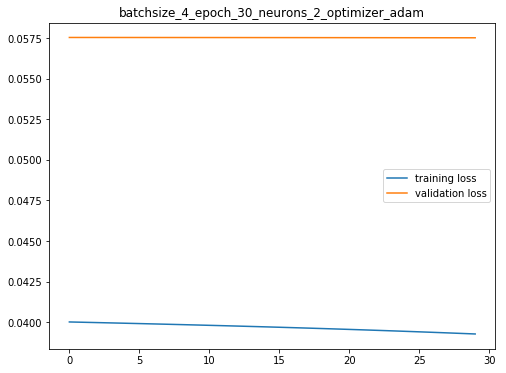

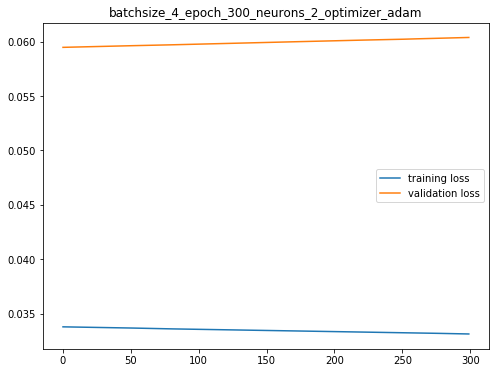

In [13]:
#loss_file='loss_20171020_2342_batchsize_4_epoch_30_neurons_2_optimizer_adam_log.csv'

def plot_training_and_val_loss(loss_file):
    rmse_loss= pd.read_csv('logs/%s' %loss_file)
    title="_".join(loss_file.split('_')[3:-1])
    plt.figure(figsize=(8,6))
    plt.plot(rmse_loss.epoch, rmse_loss.loss, label='training loss')
    plt.plot(rmse_loss.epoch, rmse_loss.val_loss, label='validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_training_and_val_loss('loss_20171020_2342_batchsize_4_epoch_30_neurons_2_optimizer_adam_log.csv')
plot_training_and_val_loss('loss_20171021_0017_batchsize_4_epoch_300_neurons_2_optimizer_adam_log.csv')